<a href="https://colab.research.google.com/github/gustavoteixeirah/dataset-celulas-malaria/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import mlflow

mlflow.set_tracking_uri(uri="http://localhost:8080")


In [2]:
import os

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Define folder paths
# FOLDER = "/content/drive/MyDrive/dataset.celulas"
FOLDER = "dataset.celulas"
PARASITIZED_FOLDER = os.path.join(FOLDER, "Parasitized/")
UNINFECTED_FOLDER = os.path.join(FOLDER, "Uninfected/")



In [3]:
from skimage.io import imread  # Assuming you have scikit-image installed
from skimage.transform import resize  # Correct import for the resize function
import time

target_size = (128, 128)

# Function to load and preprocess images with progress counter
def load_and_preprocess_image(folder_path, image_name, start_time):
    image_path = os.path.join(folder_path, image_name)
    image = imread(image_path, as_gray=True)  # Read as grayscale
    image = resize(image, target_size)  # Resize to target dimensions
    # You can add further preprocessing steps here (e.g., normalization)

    # Print progress every 1000 images
    if (len(parasitized_images) + len(uninfected_images)) % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {len(parasitized_images) + len(uninfected_images)} images in {elapsed_time:.2f} seconds.")

    return image


# Load image data
parasitized_images = []
uninfected_images = []
start_time = time.time()  # Start time for progress tracking
print(f"{start_time:.2f} seconds.")

# Limit to loading only 2000 images each
image_count = 0

for image_name in os.listdir(PARASITIZED_FOLDER):
    if (image_name.split('.')[1] == 'png') and image_count < 2000:
        parasitized_images.append(load_and_preprocess_image(PARASITIZED_FOLDER, image_name, start_time))
        image_count += 1

image_count = 0

for image_name in os.listdir(UNINFECTED_FOLDER):
    if (image_name.split('.')[1] == 'png') and image_count < 2000:
        uninfected_images.append(load_and_preprocess_image(UNINFECTED_FOLDER, image_name, start_time))
        image_count += 1

# Print final message after processing all images
elapsed_time = time.time() - start_time
print(f"Finished processing all images in {elapsed_time:.2f} seconds.")

1724282006.63 seconds.
Processed 0 images in 0.01 seconds.
Processed 1000 images in 1.28 seconds.
Finished processing all images in 2.55 seconds.


In [4]:
print(f"Shape of first parasitized image: {parasitized_images[0].shape}")
print(f"Shape of first uninfected image: {uninfected_images[0].shape}")

Shape of first parasitized image: (128, 128)
Shape of first uninfected image: (128, 128)


In [5]:
import numpy as np

# Combine images and labels (assuming labels are 0 for uninfected, 1 for parasitized)
X = np.concatenate((np.array(parasitized_images), np.array(uninfected_images)))
y = np.array([1] * len(parasitized_images) + [0] * len(uninfected_images))
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (2000, 128, 128)
Shape of y: (2000,)


In [6]:
# Split data into training and testing sets (consider using scikit-learn's train_test_split)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (1600, 128, 128)
Shape of y_train: (1600,)


In [7]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [8]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

print(X_train_flat.shape)
print(X_test_flat.shape)

(1600, 16384)
(400, 16384)


In [9]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import mlflow
from mlflow.models import infer_signature

# Variáveis para armazenar o melhor modelo e a melhor métrica
best_model = None
best_accuracy = 0.0

def objective(trial):
    # Definir o espaço de busca para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 5, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 30)

    # Cria modelo
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "random_state": 42,
    }
    
    model = RandomForestClassifier(**params)

    # Inicia a execução do MLflow
    mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
    mlflow.set_experiment("MLflow Quickstart")
    
    with mlflow.start_run(nested=True):
        model.fit(X_train_flat, y_train.flatten())  # Treina
        y_pred = model.predict(X_test_flat)  # Infere
        accuracy = accuracy_score(y_test, y_pred)  # Calcula métrica

        # Atualize o melhor modelo se necessário
        global best_model, best_accuracy
        if accuracy > best_accuracy:
            best_model = model
            best_accuracy = accuracy

        # Log dos parâmetros e métrica
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.set_tag("Malaria Cells", "Optuna optimization run")

        # Inferir e logar a assinatura do modelo
        signature = infer_signature(X_train_flat, model.predict(X_train_flat))
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="malaria_rf_model",
            signature=signature,
            input_example=X_train_flat,
            registered_model_name="malaria-cell-random-forest",
        )

    return accuracy

# Cria estudo a ser otimizado
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

# Imprime a evolução dos modelos ao final da otimização
print(f'Melhor solução:')
trial = study.best_trial

print(f'Valor: {trial.value}')
print(f'Parâmetros: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


/home/teixeira/code/dataset-celulas-malaria/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-08-21 20:13:29,695] A new study created in memory with name: no-name-fcd8c959-12c6-4a4a-a79c-fadedf71f0c8
2024/08/21 20:14:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'malaria-cell-random-forest' already exists. Creating a new version of this model...
2024/08/21 20:14:16 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: malaria-cell-random-forest, version 3
Created version '3' of model 'malaria-cell-random-forest'.


Resultados de Teste
Acurácia: 0.76
F1 score: 0.76


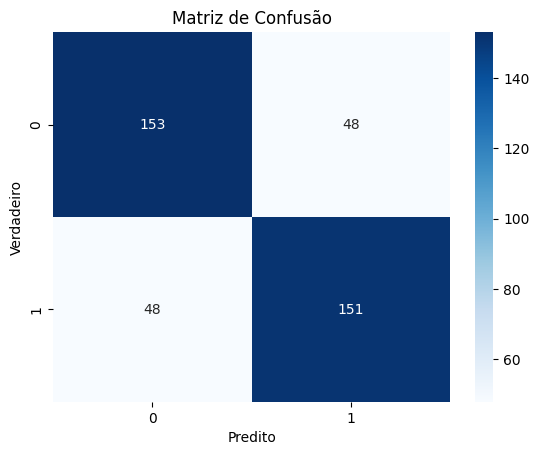

Resultados de Treino
Acurácia: 1.0
F1 score: 1.0


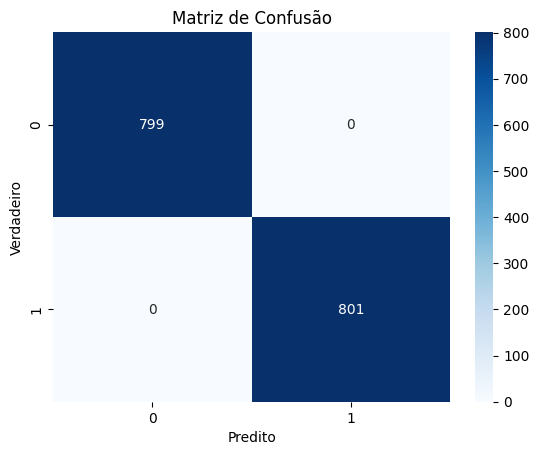

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix

# Inferência e avaliação
def predict_and_evaluate(model, X_test, y_test, normalize=None):

  # Inferência
  y_pred = model.predict(X_test)

  # Métricas
  print('Acurácia:', accuracy_score(y_test, y_pred))
  print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

  # Matriz de confusão
  conf_matrix = confusion_matrix(y_test, y_pred, normalize=normalize)

  fmt = '.2f' if normalize == 'true' else 'd'
  sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Matriz de Confusão')
  plt.xlabel('Predito')
  plt.ylabel('Verdadeiro')
  plt.show()

print('Resultados de Teste')
predict_and_evaluate(model, X_test_flat, y_test)
print('Resultados de Treino')
predict_and_evaluate(model, X_train_flat, y_train)

In [ ]:
from sklearn.cluster import KMeans


# Treinamento de um modelo Random Forest
def trainKMeans(X_train, y_train, n_clusters=5):
  model = KMeans(n_clusters=n_clusters)
  model.fit(X_train, y_train.flatten())
  return model

model = trainKMeans(X_train_flat, y_train)

Resultados de Teste
Acurácia: 0.2625
F1 score: 0.3554736101510813


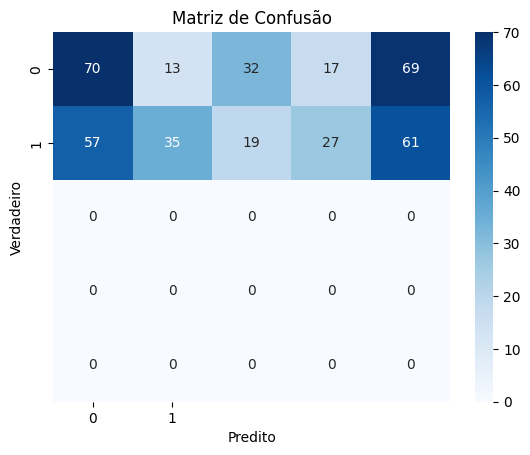

Resultados de Treino
Acurácia: 0.24875
F1 score: 0.32619903606926876


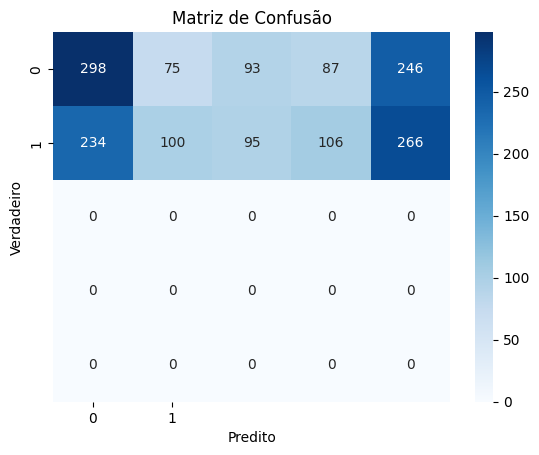

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix

# Inferência e avaliação
def predict_and_evaluate(model, X_test, y_test, normalize=None):

  # Inferência
  y_pred = model.predict(X_test)

  # Métricas
  print('Acurácia:', accuracy_score(y_test, y_pred))
  print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

  # Matriz de confusão
  conf_matrix = confusion_matrix(y_test, y_pred, normalize=normalize)

  fmt = '.2f' if normalize == 'true' else 'd'
  sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Matriz de Confusão')
  plt.xlabel('Predito')
  plt.ylabel('Verdadeiro')
  plt.show()

print('Resultados de Teste')
predict_and_evaluate(model, X_test_flat, y_test)
print('Resultados de Treino')
predict_and_evaluate(model, X_train_flat, y_train)

# Resultados de Teste
# Acurácia: 0.78125
# F1 score: 0.7813988772746686
